# **Extraction des limites des centrales photovoltaïques sur des images aériennes**                
 ---------------------------------------------------------------------------------
 **- EL MOUKHTAR Abdelmalek                                                        
      - E-mail: abdelmalekelmoukhtar@gmail.com                  
      - E-mail: elmoukhtar99@gmail.com**                     




In [1]:
#install tensorflow gpu
!pip install -U tensorflow-gpu==2.0.0 grpcio
#
#!pip install --upgrade tensorflow
#!pip install --upgrade tensorflow-gpu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 380.8 MB 38 kB/s 
     |████████████████████████████████| 50 kB 8.0 MB/s 
     |████████████████████████████████| 449 kB 75.6 MB/s 
     |████████████████████████████████| 3.8 MB 48.2 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=14c78acdbff9e57850fbedc467ef601b082908576620e2fff5b19ed00aca4729
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting un

In [2]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.


# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
#for download the dataset
#Fill the ... with the id of dataset.zip in your google drive

download = drive.CreateFile({'id': '1FlNvqpmzP9G_qqv1boaCHmtAmwn8KCvm'})
download.GetContentFile('rotated_3100.zip')

# unzip your file
! unzip rotated_3100.zip

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: rotated_3100/train/x/img1881.jpg  
  inflating: rotated_3100/train/x/img1882.jpg  
  inflating: rotated_3100/train/x/img1883.jpg  
  inflating: rotated_3100/train/x/img1884.jpg  
  inflating: rotated_3100/train/x/img1885.jpg  
  inflating: rotated_3100/train/x/img1886.jpg  
  inflating: rotated_3100/train/x/img1887.jpg  
  inflating: rotated_3100/train/x/img1888.jpg  
  inflating: rotated_3100/train/x/img1889.jpg  
  inflating: rotated_3100/train/x/img189.jpg  
  inflating: rotated_3100/train/x/img1890.jpg  
  inflating: rotated_3100/train/x/img1891.jpg  
  inflating: rotated_3100/train/x/img1892.jpg  
  inflating: rotated_3100/train/x/img1893.jpg  
  inflating: rotated_3100/train/x/img1894.jpg  
  inflating: rotated_3100/train/x/img1895.jpg  
  inflating: rotated_3100/train/x/img1896.jpg  
  inflating: rotated_3100/train/x/img1897.jpg  
  inflating: rotated_3100/train/x/img1898.jpg  
  inflating

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
path='/content/drive/MyDrive/FCN_Data/dataset'

In [19]:
#from tensorflow import keras 
!pip install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [20]:
# Run it to obtain reproducible results across machines (from keras.io)
#from keras import backend as K
import tensorflow as tf
from tensorflow.keras import backend as k
import numpy as np
import tensorflow as tf
import os, glob
import matplotlib.pyplot as plt

import keras
from tensorflow.keras.preprocessing import image as kImage
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import load_img, img_to_array

#session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

#sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
#tf.compat.v1.keras.backend.set_session(sess)
#K.set_session(sess)

ImportError: ignored

In [ ]:
"""
Just for uploading a trained model - When there is no need to train a new model.
Get the shareable id same as the way of dataset.zip.
"""
download = drive.CreateFile({'id': '...'})
download.GetContentFile('trained_model.h5')

model = load_model('trained_model.h5')

In [ ]:
# load data function

def getData(dataset_dir):
    X_list= sorted(glob.glob(os.path.join(dataset_dir, 'x','*.jpg')))
    Y_list = sorted(glob.glob(os.path.join(dataset_dir, 'y' ,'*.png')))
    
    X= []
    Y= []
    for i in range(len(X_list)):
        # Load input image
        x = kImage.load_img(X_list[i])
        x = kImage.img_to_array(x)
        x /= 255.0
        X.append(x)
        
        # Load ground-truth label and encode it to label 0 and 1
        y = kImage.load_img(Y_list[i], grayscale = True)
        y = kImage.img_to_array(y)
        y /= 255.0
        y = np.floor(y)
        Y.append(y)
    X = np.asarray(X)
    Y = np.asarray(Y)
    
    # Shuffle the training data
    idx = list(range(X.shape[0]))
    np.random.shuffle(idx)
    X = X[idx]
    Y = Y[idx]
    return X, Y

In [ ]:
"""
Structure of the enocder-decoder network
This network is used for supervised image segmentation tasks.
Here, we used 17 layers of VGG16 as an encoder for feature extraction.
"""

def initModel():
    ### Encoder
    net_input = Input(shape=(240,320,3))
    vgg16 = tf.compat.v1.keras.applications.vgg16.VGG16(include_top=False, weights='imagenet', input_tensor=net_input)

    for layer in vgg16.layers[:17]:
        layer.trainable = False

    x = vgg16.layers[-2].output # output of the ENCODER: 2nd layer from the last, < block5_conv3 >
   # x = vgg19.layers[-2].output # output of the ENCODER: 2nd layer from the last, < block5_conv3 >

    ### Decoder
    x = tf.keras.layers.Conv2DTranspose(256, (3,3), strides=(2,2), activation='relu', padding='same')(x)
    x = tf.keras.layers.Conv2DTranspose(128, (3,3), strides=(2,2), activation='relu', padding='same')(x)
    x = tf.keras.layers.Conv2DTranspose(64, (3,3), strides=(2,2), activation='relu', padding='same')(x)
    x = tf.keras.layers.Conv2DTranspose(32, (3,3), strides=(2,2), activation='relu', padding='same')(x)
    x = tf.keras.layers.Conv2DTranspose(1, (1,1), activation='sigmoid', padding='same')(x)
    
    model = Model(inputs = vgg16.input, outputs = x)
    model.compile(loss = tf.keras.losses.binary_crossentropy, optimizer = tf.keras.optimizers.RMSprop(lr=5e-4), metrics=['accuracy'])
    model.summary()

    return model

In [ ]:
model = initModel()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 240, 320, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 240, 320, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 240, 320, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 120, 160, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 120, 160, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 120, 160, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 60, 80, 128)       0     

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
# load train data
#dataset_path = os.path.join('path/dataset/train')
dataset_path = os.path.join('rotated_3100/train')
X, Y = getData(dataset_path)

# init the model
model = initModel()

early = tf.compat.v1.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=10)
reduce = tf.compat.v1.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)



/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 240, 320, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 240, 320, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 240, 320, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 120, 160, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 120, 160, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 120, 160, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 60, 80, 128)       0   

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
#training process
history = model.fit(X, Y, batch_size=32, epochs=15, verbose=2, validation_split=0.2, callbacks=[reduce, early], shuffle=True)
model.save('trained_model.h5')

Epoch 1/15
75/75 - 96s - loss: 0.4247 - accuracy: 0.7961 - val_loss: 0.2943 - val_accuracy: 0.8731 - lr: 5.0000e-04 - 96s/epoch - 1s/step
Epoch 2/15
75/75 - 72s - loss: 0.2849 - accuracy: 0.8804 - val_loss: 0.3335 - val_accuracy: 0.8610 - lr: 5.0000e-04 - 72s/epoch - 954ms/step
Epoch 3/15
75/75 - 72s - loss: 0.2569 - accuracy: 0.8910 - val_loss: 0.2254 - val_accuracy: 0.9065 - lr: 5.0000e-04 - 72s/epoch - 956ms/step
Epoch 4/15
75/75 - 72s - loss: 0.2317 - accuracy: 0.9041 - val_loss: 0.2075 - val_accuracy: 0.9151 - lr: 5.0000e-04 - 72s/epoch - 954ms/step
Epoch 5/15
75/75 - 72s - loss: 0.2146 - accuracy: 0.9107 - val_loss: 0.2976 - val_accuracy: 0.8717 - lr: 5.0000e-04 - 72s/epoch - 954ms/step
Epoch 6/15
75/75 - 72s - loss: 0.1958 - accuracy: 0.9190 - val_loss: 0.1858 - val_accuracy: 0.9239 - lr: 5.0000e-04 - 72s/epoch - 956ms/step
Epoch 7/15
75/75 - 72s - loss: 0.1790 - accuracy: 0.9264 - val_loss: 0.1707 - val_accuracy: 0.9306 - lr: 5.0000e-04 - 72s/epoch - 959ms/step
Epoch 8/15
75/75

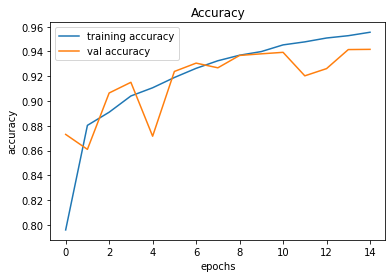

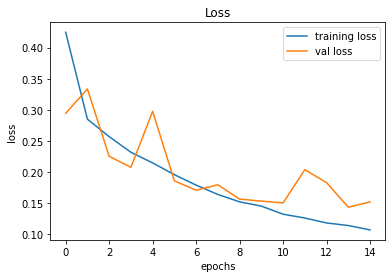

In [ ]:
#plotting graphs for accuracy 
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

#plotting graphs for Loss
plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()


In [ ]:
dataset_path = os.path.join('rotated_3100/test')
X_test, y_test = getData(dataset_path)
# predict
prediction = model.predict(X_test, verbose=2, batch_size=1)


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


110/110 - 6s - 6s/epoch - 56ms/step


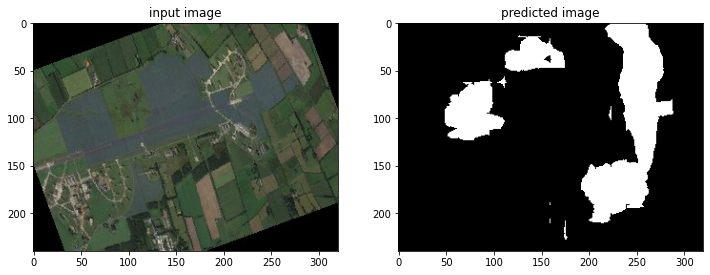

In [ ]:

plt.rcParams['figure.figsize'] = (12.0, 9.0)

idx = np.random.randint(0, X_test.shape[0])

img = np.empty(2, dtype=object)
img[0] = X_test[idx] * 255
img[1] = prediction[idx].reshape(prediction[idx].shape[0], prediction[idx].shape[1])

img[1] *= 255
for row in range(img[1].shape[1]):
    for column in range(img[1].shape[0]):
        img[1][column][row] = 255 if img[1][column][row] >= 125 else 0

title = ['input image', 'predicted image']


plt.subplot(1, 2, 1)
plt.imshow(img[0].astype('uint8'))
plt.title(title[0])

plt.subplot(1, 2, 2)
plt.imshow(img[1], cmap='gray')
plt.title(title[1])

plt.show()

In [ ]:
#download the model
from google.colab import files
files.download("trained_model.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
"""
Just for uploading a trained model - When there is no need to train a new model.
Get the shareable id same as the way of dataset.zip.
"""
download = drive.CreateFile({'id': '...'})
download.GetContentFile('trained_model.h5')

model = load_model('trained_model.h5')

ApiRequestError: ignored